## SolarForecast - Energy model building with hypertuned parameters

In [ ]:
# load libraries

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

import pickle

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# load dataset
cnx = create_engine('mysql+pymysql://<<dbuser>>:<<password>>@<<hostname>>:<<port>>/fhem', echo=False)
query = "select EnergyHour, Month, Brightness, SunAlt, SunAz, Temp from SolarEnergyFc order by Year, Month, Day, Hour"

# Using a context manager for safe resource handling
with cnx.connect() as conn:
  result = conn.execute(text(query))
  columns = result.keys() # Extract column names
  data = pd.DataFrame(result.fetchall(), columns=columns)

#ignore the last 40 record, because contain weather condition forecasts
data = data[:-40]

#map month to seassons
month_seasson_mapping = {
    1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3, 9:2, 10:2, 11:1, 12:1
}
data["Seasson"] = data["Month"].map(lambda x: month_seasson_mapping[x])


categorical_features = pd.get_dummies(data, columns = ['Seasson'])

data = pd.concat([categorical_features], axis=1)

y = data['EnergyHour'].values.copy()

data = data.drop(columns=['EnergyHour', 'Month'], axis=1)
X = pd.DataFrame(data.values.copy())

# split whole days only (20 records are one day)
test_size = int(len(X)*0.25/20)*20/len(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = test_size,shuffle=False)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

#X.head(20)

(4480, 7) (1480, 7) (4480,) (1480,)


In [4]:

# fit model
model = RandomForestRegressor(n_estimators=1788, min_samples_split=10,min_samples_leaf=6, max_features=0.6, max_depth=100, bootstrap=False)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=100, max_features=0.6,
                      min_samples_leaf=6, min_samples_split=10,
                      n_estimators=1788)

In [5]:
# make a prediction
y_pred = model.predict(X_test)
print('R^2 score: %.4f' % metrics.r2_score(y_test, y_pred))

R^2 score: 0.9474


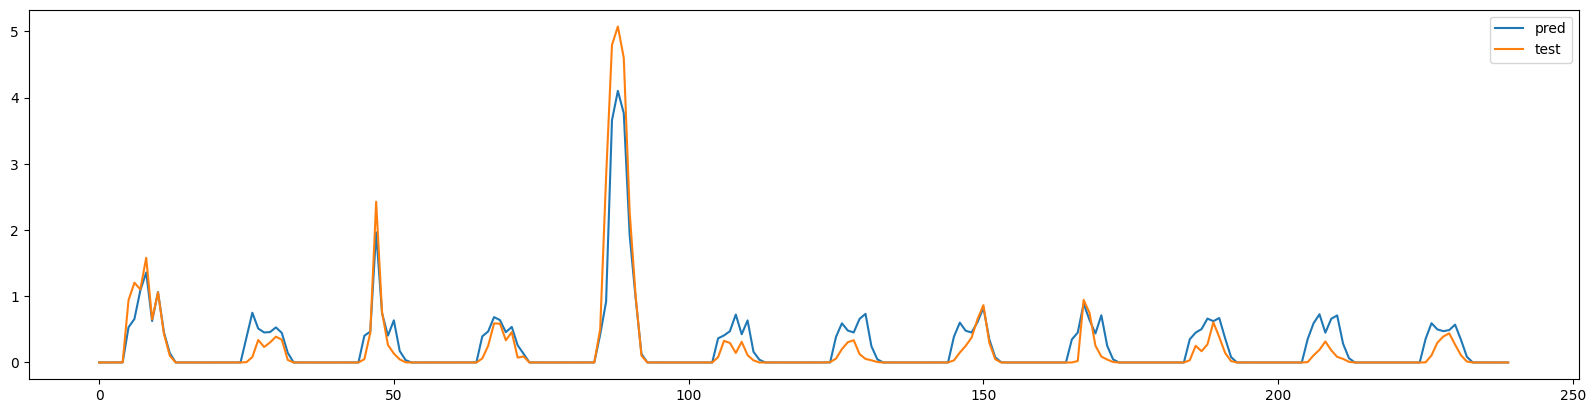

In [6]:
# plot comparision test vs. predicted values
plt.figure().set_figwidth(20)
plt.plot(y_pred[-240:], label='pred')
plt.plot(y_test[-240:], label='test')
plt.legend()
plt.show()

In [7]:
# save the model to disk
filename = './models/energy.pkl'
pickle.dump(model, open(filename, 'wb'))